In [188]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

Возьмем предсказания полученной модели для валидационной (hold-out) выборки и вектор действительных значений метки класса для той же выборки:

In [202]:
model_predictions = pd.read_csv('model_predictions.csv', index_col = 0)
y_hold_out = pd.read_csv('y_hold_out.csv',  index_col = 0)
model_predictions.head()

,0
0,0.039244
1,0.070594
2,0.024855
3,0.018099
4,0.026294


Для расчёта экономического эффекта нам потребуется знать, как меняется точность предсказания класса 'отток' при изменении порога (значения вероятности), при котором мы относим объект к этому классу.
Определим список значений порога (threshold), посчитаем, какая доля объектов при этом пороге будет отнесена к классу 'отток' (churn_top) и какая будет точность предсказания этого класса (precision churn). Запишем в таблицу.

In [203]:
bin_model_predictions = []
precision_list = []
churn_top = []
thr_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75,1]
for thr in thr_list:
    bin_model_predictions[:] = []
    bin_model_predictions = [ 1 if x > thr else -1 for x in list(model_predictions.values)]
    churn_top.append( bin_model_predictions.count(1)/float(len(bin_model_predictions)) )
    precision_list.append( metrics.precision_score( y_hold_out.values, bin_model_predictions) )
data = pd.DataFrame( zip(thr_list, churn_top, precision_list), columns = ['threshold', 'churn_top', 'precision churn'] )
data
    

,threshold,churn_top,precision churn
0,0.01,0.965027,0.077010
1,0.05,0.540164,0.111280
2,0.10,0.228689,0.170848
3,0.15,0.105464,0.233161
4,0.20,0.056284,0.262136
5,0.25,0.029235,0.345794
6,0.30,0.016393,0.383333
7,0.50,0.001366,0.800000
8,0.75,0.000000,0.000000
9,1.00,0.000000,0.000000


1. Итак, пусть у нас есть абонентская база в 10 миллионов человек (N), средний чек (ARPU) - 400 рублей. 

Людям, которых мы занесли в класс отток, мы предлагаем в начале месяца заплатить бонус - 10 % от среднего чека (retention_cost_coef). 

Допустим, вероятность удержания (человек принял бонус и не ушел), составляет 50 % (retention_proba).

Итак, выделим примерно 10 % абонентов, согласно ранжированию нашей модели, участвующих в кампании (churn_top). Точность прогноза при этом составит примерно 23 % (precision_churn).

Оценивать прибыль будем по прошествии месяца в миллионах рублей по формуле:

PROFIT = "доход" - "расходы"



In [204]:
N = 10 # млн. чел.
ARPU = 400 # руб
retention_cost_coef = 0.1
retention_proba = 0.5
top = 0.105464
precision_churn =0.233161

In [205]:
PROFIT = N * top * ARPU * (precision_churn * retention_proba - retention_cost_coef) # млн. руб.
round(PROFIT,3)

6.995

Посчитаем еще коэффициет Return of investment (ROI): (("доход" - "расходы")/"расходы" * 100 %). 
Путем несложных преобразований получаем формулу:

In [193]:
ROI = (((precision_churn * retention_proba)/ retention_cost_coef) -1 ) * 100
ROI

16.580499999999997

Для данных параметров прибыль составила 6.995 миллионов рублей. ROI - 16.6 процента. Эффективно!


2. Ищем оптимальный размер топа - к полученной в начале ноутбука таблице добавим столбец, где рассчитана прибыль, в зависимости от топа и соответствующей ему точности, остальные параметры не меняем.

In [206]:
data ['profit'] =  N * data['churn_top'] * ARPU * (data['precision churn'] * retention_proba - retention_cost_coef)
data 

,threshold,churn_top,precision churn,profit
0,0.01,0.965027,0.077010,-237.377049
1,0.05,0.540164,0.111280,-95.846995
2,0.10,0.228689,0.170848,-13.333333
3,0.15,0.105464,0.233161,6.994536
4,0.20,0.056284,0.262136,6.994536
5,0.25,0.029235,0.345794,8.524590
6,0.30,0.016393,0.383333,6.010929
7,0.50,0.001366,0.800000,1.639344
8,0.75,0.000000,0.000000,-0.000000
9,1.00,0.000000,0.000000,-0.000000


Наибольшая прибыль (~ 8.5 млн. руб. за месяц) достижима при размере топа - 2.9 %. Когда мы привлекаем к кампании почти всех абонентов (вероятность оттока 1 %) - убытки максимальны (~ 237 млн. руб. за месяц); когда ограничиваемся размером топа 0.13 % - прибыль уменьшается до ~ 1.6 млн. руб. в месяц.

3. На мой взгляд, модель и так достаточно сложная для дилетантской оценки, но, чтобы соблюсти формальности, будем вычитать из предполагаемой прибыли ещё и общую стоимость затрат на мероприятия по удержанию оттока, пусть эта стоимость составит 0.5 млн. руб. в месяц (параметр implementation_cost)
Меняем вероятность удержания абонентов (retention_proba), задаем значения: [0.1, 0.25, 0.5, 0.75, 0.95]

In [195]:
implementation_cost = 0.5

In [196]:
#вероятность удержания
rp_list = [0.1, 0.25, 0.5, 0.75, 0.95]
profit_rp = []
opt_top_rp = []
for rp in rp_list:
    data ['profit_rp'] =  N * data['churn_top'] * ARPU * (data['precision churn'] * rp - retention_cost_coef) - implementation_cost
    profit_rp.append (max(data.profit_rp))
    zdd = data[data.profit_rp == max(data.profit_rp)] ['churn_top']
    opt_top_rp.append( zdd.values [0] )
pd.DataFrame( zip(rp_list, opt_top_rp, profit_rp), columns = ['retention_proba','opt_top','profit'])

,retention_proba,opt_top,profit
0,0.10,0.000000,-0.500000
1,0.25,0.001366,0.046448
2,0.50,0.029235,8.024590
3,0.75,0.105464,31.084699
4,0.95,0.228689,56.494536


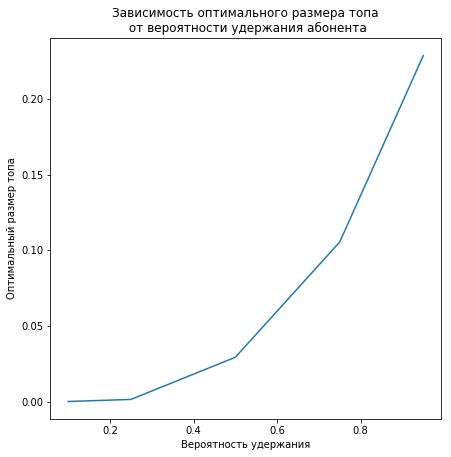

In [197]:
plt.figure(figsize=(7, 7))
plt.plot(rp_list, opt_top_rp)
plt.xlabel(u"Вероятность удержания")
plt.ylabel(u"Оптимальный размер топа")
plt.title(u'Зависимость оптимального размера топа\n от вероятности удержания абонента')
plt.show()

Здесь мы не видим ничего удивительного: при малой вероятности удержания клиента - 0.1, нам вообще убыточно проводить кампанию. При высокой вероятности удержания (0.95) нам выгодно увеличить топ до 22.8 %.


Изменим стоимость удержания - будем брать 0.1, 0.15, 0.2, 0.3, 0.5 долей от ARPU.

In [198]:
#стоимость удержания
rcc_list = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
profit_rcc = []
opt_top_rcc = []
for rcc in rcc_list:
    data ['profit_rcc'] =  N * data['churn_top'] * ARPU * (data['precision churn'] * retention_proba - rcc) - implementation_cost
    profit_rcc.append (max(data.profit_rcc))
    zdd = data[data.profit_rcc == max(data.profit_rcc)] ['churn_top']
    opt_top_rcc.append( zdd.values [0] )
pd.DataFrame( zip(rcc_list, opt_top_rcc, profit_rcc), columns = ['retention_cost_coef','opt_top','profit'])

,retention_cost_coef,opt_top,profit
0,0.05,0.228689,31.904372
1,0.10,0.029235,8.024590
2,0.15,0.016393,2.232240
3,0.20,0.001366,0.592896
4,0.30,0.001366,0.046448
5,0.50,0.000000,-0.500000


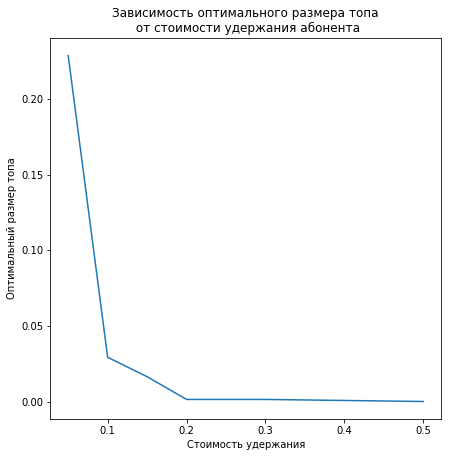

In [175]:
plt.figure(figsize=(7, 7))
plt.plot(rcc_list, opt_top_rcc)
plt.xlabel(u"Стоимость удержания")
plt.ylabel(u"Оптимальный размер топа")
plt.title(u'Зависимость оптимального размера топа\n от стоимости удержания абонента')
plt.show()

Оптимальный размер топа падает с увеличением размера бонуса. При бонусе 40% прибыль станет незначительной, а при бонусе 50% кампания будет убыточной. Но нужно иметь ввиду, что чем меньше размер бонуса, тем меньше вероятность удержать клиента - в реальности зависимость будет более сложной.


4. Выше мы уже увидели, что применение модели не всегда экономически оправданно. Приведем пример - повысим в параметрах расчёта из 1-го пункта стоимость удержания с 0.1 до 0.2 - получим убыток свыше 35 миллионов рублей:

In [199]:
N = 10 # млн. чел.
ARPU = 400 # руб
retention_cost_coef = 0.2
retention_proba = 0.5
top = 0.105464
precision_churn =0.233161

PROFIT = N * top * ARPU * (precision_churn * retention_proba - retention_cost_coef) # млн. руб.
round(PROFIT,3)

-35.191

5. Возьмем экономическую модель (пункт 1) с оптимальным топом (пункт 2), дающую прибыль 8.525 млн. руб. Увеличим точность отнесения к классу 'отток' на 1 %, пофантазируем и заложим стоимость увеличения точности - 50 тыс. руб. Считаем прибыль.

In [183]:
# precision +0.01
cost_of_improvement = 0.05
N = 10 # млн. чел.
ARPU = 400 # руб
retention_cost_coef = 0.1
retention_proba = 0.5
top = 0.029235
precision_churn = 0.345794 + 0.01

PROFIT = N * top * ARPU * (precision_churn * retention_proba - retention_cost_coef) - cost_of_improvement
round(PROFIT,3)

9.059

Увеличение прибыли на 0.5 млн. руб. при дополнительных вложениях 0.05 млн. руб. - да, экономически оправданно!

Рассмотрим увеличение точности на 3%, повысим стоимость улучшений до 200 тыс. руб.

In [184]:
# precision +0.03
cost_of_improvement = 0.2
N = 10 # млн. чел.
ARPU = 400 # руб
retention_cost_coef = 0.1
retention_proba = 0.5
top = 0.029235
precision_churn = 0.345794 + 0.03

PROFIT = N * top * ARPU * (precision_churn * retention_proba - retention_cost_coef) - cost_of_improvement
round(PROFIT,3)

10.079

Получаем увеличении прибыли свыше 1.5 млн.руб. при вложении 0.2 млн. руб. И это за месяц. 

6. Даже при увеличении точности всего на 0.5 % при стоимости улучшений 50 тыс. руб., наша экономическая модель показывает качественное улучшение - почти 3%:

In [185]:
# precision +0.005
cost_of_improvement = 0.05
N = 10 # млн. чел.
ARPU = 400 # руб
retention_cost_coef = 0.1
retention_proba = 0.5
top = 0.029235
precision_churn = 0.345794 + 0.005

PROFIT = N * top * ARPU * (precision_churn * retention_proba - retention_cost_coef) - cost_of_improvement
round(PROFIT,3)

8.767

In [186]:
(8.767-8.525)/8.525 *100

2.8387096774193443

Хоть приведенная экономическая модель далека от реальности, я считаю, что вложение средств в улучшение качества модели является экономически оправданным. Но улучшать качество можно до какого-то предела, после которого улучшения будут уже либо не оправданны, либо в принципе невозможны. Насколько мне известно от участников хакатонов - компании борются за увеличение качества на проценты и десятые доли процента. А вот сотые доли процента, за которые борются участники соревнований по машинному обучению, в продакшн уже не так важны.